# Sparse CNNs
I have been considering starting a project to estimate the likelyhood that a [snooker](https://www.youtube.com/watch?v=V1s9oC5ebFs) player wins the game without missing. One important factor would be arrangement of the balls on the table; one might consider using a CNN to classify the opportunity offered to player at the start of their turn, given a picture of the snooker table. The only useful information specific to each picture would be the coordinates of each of the balls (max 22 x 2 numbers), but the input would need to be represented as a 2D image for the CNN to make use of spatial information. For this use case, one could probably get away with shrinking the input significantly, but if that was not possible, most of the processing time would be wasted on convolutions over zero-valued pixels.

Several research groups have recently published implementations wihch address input sparsity directly, including [Facebook](https://github.com/facebookresearch/SparseConvNet) (Torch implementation) and [Intel](https://github.com/IntelLabs/SkimCaffe) (Caffe implementation). The former applies the approach to pen strokes and 3D point clouds.

As a learning exercise, I decided to implement the Facebook approach in TensorFlow. I couldn't find any existing TensorFlow implementations when starting, but [this feature request](https://github.com/tensorflow/tensorflow/issues/1604) exists and has some 
recent activity.

I discuss aspects of the implementation here, but see the python project [files](https://github.com/IdRatherBeCoding/sparse_cnn/tree/master/sparse_cnn_tensorflow) and [unit tests](https://github.com/IdRatherBeCoding/sparse_cnn/tree/master/tests/sparse_cnn_tensorflow) for full details.

## The algorithm
I worked with the following brief guide from an [earlier paper](https://arxiv.org/abs/1505.02890) on the same work.

<img src="algorithm.jpg" width="50%" height="50%">

So the approach is to iterate through the active sites of the sparse input and build a list of the active sites in the output, while placing the input values that contribute to an output value in the intermediate matrix Q. (_Active site_ refers to nonzero values in the typical sense, but in general the _ground state_ value will become nonzero itself after the first layer, due to bias terms).

Each row of Q corresponds to an output active site, and the positioning of the input values in each row matches the ordering of the filter weights, stored in matrix W.

The author implements step 1 on the CPU and steps 2 and 3 on the GPU.
In this project I implement steps 1 and 2 in python using the special [tf.py_func](https://www.tensorflow.org/api_docs/python/tf/py_func) function for creating custom ops. For future work, I intend to implement an efficient version in C++.
For the dense matrix multiplication in step 3, I simply use TensorFlow's matmul op.

## Representation of sparse data
TensorFlow has good general support for sparse tensors. The [tf.SparseTensor](https://www.tensorflow.org/api_docs/python/tf/SparseTensor) class represents sparse data with an indices array, containing all the positions of the active sites, a values array and a record of the dense shape. For the approach I'm following here, a spatial position is considered active for all channels if any of the channels has an active value in that position.

I created a custom class to represent this alternative form, and to provide methods for converting between dense and sparse forms.

In [1]:
from sparse_cnn_tensorflow.sparse_cnn import sparse_conv_2d
from sparse_cnn_tensorflow.sparse_data_value import SparseDataValue
from sparse_cnn_tensorflow.sparse_data_tensor import SparseDataTensor

## Build H<sub>out</sub> and Q
The function [build_h_out_and_Q](https://github.com/IdRatherBeCoding/sparse_cnn/blob/a68f2205d827cc7851055fc07be7cd6c27f0cedd/sparse_cnn_tensorflow/sparse_cnn.py#L17) first takes the sparse input components (H<sub>in</sub>, M<sub>in</sub>), iterates through H<sub>in</sub> and counts the number, a<sub>out</sub>, and positions of output active sites.

In [ ]:
    output_sites = {}
    # enumerate all output active sites and store the positions
    i_out = 0
    for [row, col] in H_in:
        for i, j in filter_positions(row, col, height, width, f):
            if (i, j) not in output_sites:
                output_sites[(i, j)] = i_out
                i_out += 1

    a_out = i_out

For each active spatial position in H<sub>in</sub>, we iterate over the generator *filter_positions*, which provides the valid positions of the filter as it slides around the active site.

I am only supporting strides of 1, but this is where support for strides could be added.

In [ ]:
def filter_positions(row, col, height, width, f):
    # slide filter around this point to generate valid output positions
    for irow in range(max(row - f + 1, 0), min(row + 1, height - f + 1)):
        for icol in range(max(col - f + 1, 0), min(col + 1, width - f + 1)):
            yield (irow, icol)

Now that we know a<sub>out</sub>, we can initialize the matrices H<sub>out</sub> and Q.

In [ ]:
    h_out = np.empty((a_out, 2), dtype=H_in.dtype)
    q = np.empty((a_out, f * f, n_in), dtype=M_in.dtype)
    for (i_gs, gs) in enumerate(ground_state):
        q[:, :, i_gs] = gs
    q = q.reshape((a_out, f * f * n_in))

Finally we enumerate all output active sites again, populating H<sub>out</sub> and Q as we go.

In [ ]:
    for idx, [row, col] in enumerate(H_in):
        values = M_in[idx]
        for i, j in filter_positions(row, col, height, width, f):
            i_out = output_sites[(i, j)]
            h_out[i_out, 0] = i
            h_out[i_out, 1] = j
            for i_val, value in enumerate(values):
                q[i_out, position_in_filter(i, j, row, col, f, i_val, n_in)] = value

For each position of the filter for active site a<sub>i</sub>, we need to know the index in the row Q[a<sub>i</sub>] that corresponds to the correct weight in W. In TensorFlow, the shape of the filter weights (see [here](https://www.tensorflow.org/versions/master/api_docs/python/tf/nn/conv2d)) is [filter_height, filter_width, in_channels, out_channels]. To make it easy to compare to TensorFlow, I choose the same ordering:

In [ ]:
def position_in_filter(filter_row, filter_col, site_row, site_col, f, c_in, n_in):
    return c_in + (site_col - filter_col) * n_in + (site_row - filter_row) * f * n_in

## Create custom operation with *py_func*
So far we have been working _numpy_ arrays. We can create a custom Op that can be used as part of a TensorFlow graph:

In [ ]:
    H_out, Q = tf.py_func(build_h_out_and_Q,
                          [H_in, M_in, dense_shape, f, n_in, ground_state],
                          [H_in.dtype, M_in.dtype])

This is a very convenient way to try out new operations without having to go through the full procedure of [creating a new op](https://www.tensorflow.org/extend/adding_an_op) in C++. Of course, once the approach is validated, this effort is required for the sake of efficiency.

H_out and Q in the above code snippet are Tensors, so we can compute M<sub>out</sub> as part of the graph.

In [ ]:
    M_out = tf.add(tf.matmul(Q, W), b)

We also need to calculate the value of the output ground-state.

In [ ]:
# W has shape (f*f*n_in, n_out)
# tf.nn.conv_2d has W shape (batch_size, f, f, n_in, n_out)
# so gs_n should have comparable ordering for product.
def next_ground_state(W, gs_in, f):
    gs_1 = tf.reshape(gs_in, (-1, 1))
    gs_n = tf.tile(gs_1, [f * f, 1])
    return tf.reshape(tf.matmul(W, gs_n, transpose_a=True), [-1])

## Putting it all together
Create a function that takes as input a SparseDataTensor (the tf.Tensor counterpart to my SparseDataValue mentioned earlier), and outputs another SparseDataTensor.

In [ ]:
def sparse_conv_2d(sparse_input, W, f, n_out, b):
    # b should just be 1-D tensor of biases, length n_out

    H_in = sparse_input.H
    M_in = sparse_input.M
    dense_shape = sparse_input.dense_shape
    n_in = dense_shape[2]
    ground_state = sparse_input.ground_state

    output_spatial_shape = (dense_shape[0] - f + 1, dense_shape[1] - f + 1)

    H_out, Q = tf.py_func(build_h_out_and_Q,
                          [H_in, M_in, dense_shape, f, n_in, ground_state],
                          [H_in.dtype, M_in.dtype])

    M_out = tf.add(tf.matmul(Q, W), b)

    output_dense_shape = (output_spatial_shape[0], output_spatial_shape[1], n_out)

    output_ground_state = next_ground_state(W, ground_state, f) + b

    return SparseDataTensor(H_out, M_out, output_dense_shape, output_ground_state)

Checkout the [unit tests](https://github.com/IdRatherBeCoding/sparse_cnn/tree/master/tests/sparse_cnn_tensorflow) for simple examples of input.

## Sparse CNN on a real image
We will now compare the output of the tf.nn.conv2d op, and the sparse implementation presented here.

If we use the same weights and biases, the output from the two implementations should agree exactly, to within numerical precision.

Two images will be tested: an image of a dog with no sparsity, and the same image with the background deleted.

In [2]:
import numpy as np
import tensorflow as tf
from PIL import Image
import PIL
import matplotlib.pylab as plt
%matplotlib inline

from sparse_cnn_tensorflow.sparse_cnn import sparse_conv_2d

(-0.5, 127.5, 127.5, -0.5)

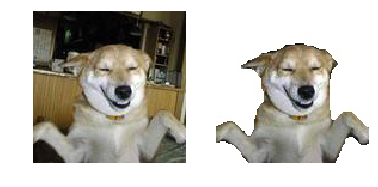

In [3]:
dog_bg = Image.open("dog_with_bg.jpg")
dog_no_bg = Image.open("dog_without_bg.jpg")
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(dog_bg)
plt.axis('off')
ax2 = fig.add_subplot(122)
ax2.imshow(dog_no_bg)
plt.axis('off')

#### Create an image by averaging over output channels to disply the result of each convolutional layer
This doesn't do much more than show progressiely blurry dogs, but it's good check that the sparse and dense convolution outputs are the same. Visualising the filters won't be informative becaue we'll be using random values.

In [4]:
def visualise_output(dense):
    nc = dense.shape[2]
    nc1 = nc // 3
    nc2 = nc // 3
    nc3 = nc - nc1 - nc2
    a = np.empty((dense.shape[0], dense.shape[1], 3))
    a[:, :, 0] = np.mean(dense[:, :, 0:nc1], axis=2)
    a[:, :, 1] = np.mean(dense[:, :, nc1:nc1+nc2], axis=2)
    a[:, :, 2] = np.mean(dense[:, :, nc2:nc], axis=2)
    max_val = np.max(dense)
    if max_val > 0.0:
        a = a * (255 / max_val)
    return Image.fromarray(a.astype(np.uint8))

def compare_layer(sparse_output, dense_output):
    with tf.Session() as sess:
        s = sparse_output.to_value(sess).to_dense()
        d = np.squeeze(sess.run(dense_output))
        diff = np.abs(s - d)

        fig = plt.figure(frameon=False)
        ax1 = fig.add_subplot(131)
        ax1.imshow(visualise_output(s))
        plt.axis('off')
        ax2 = fig.add_subplot(132)
        ax2.imshow(visualise_output(d))
        plt.axis('off')
        ax3 = fig.add_subplot(133)
        ax3.imshow(visualise_output(diff))
        plt.axis('off')
        
        return s, d, diff

#### Create SparseDataValue and SparseDataTensor objects for our two images

In [5]:
dog_bg_arr = np.asarray(dog_bg).astype(np.float32)
dog_bg_value = SparseDataValue(dog_bg_arr)
dog_bg_tensor = SparseDataTensor(dog_bg_value.H, dog_bg_value.M, dog_bg_value.dense_shape, dog_bg_value.ground_state)
dog_bg_tf = tf.constant(dog_bg_arr, shape=[1, 128, 128, 3])

In [6]:
dog_no_bg_arr = np.asarray(dog_no_bg).astype(np.float32)
dog_no_bg_value = SparseDataValue(dog_no_bg_arr)
dog_no_bg_tensor = SparseDataTensor(
    dog_no_bg_value.H, dog_no_bg_value.M, dog_no_bg_value.dense_shape, dog_no_bg_value.ground_state)
dog_no_bg_tf = tf.constant(dog_no_bg_arr, shape=[1, 128, 128, 3])

#### Initialise the weights and biases for three layers

In [7]:
f1 = 3
n_in_1 = 3
n_out_1 = 4

f2 = 5
n_out_2 = 8

f3 = 10
n_out_3 = 16

W1 = tf.constant(np.random.rand(f1*f1*n_in_1, n_out_1), dtype=tf.float32)
b1 = tf.constant(np.random.rand(n_out_1), dtype=tf.float32)

W2 = tf.constant(np.random.rand(f2*f2*n_out_1, n_out_2), dtype=tf.float32)
b2 = tf.constant(np.random.rand(n_out_2), dtype=tf.float32)

W3 = tf.constant(np.random.rand(f3*f3*n_out_2, n_out_3), dtype=tf.float32)
b3 = tf.constant(np.random.rand(n_out_3), dtype=tf.float32)

In [8]:
def build_3_layers_for_each_implementation(sparse_input_tensor, dense_input_tensor):
    # layer 1
    sparse_conv_1 = sparse_conv_2d(sparse_input_tensor, W1, f1, n_out_1, b1)
    sparse_A1 = sparse_conv_1.apply_relu()

    dense_conv_1 = tf.nn.conv2d(dense_input_tensor, tf.reshape(W1, [f1, f1, n_in_1, n_out_1]), strides=[1, 1, 1, 1], padding="VALID")
    dense_A1 = tf.nn.relu(tf.nn.bias_add(dense_conv_1, b1))

    # layer 2
    sparse_conv_2 = sparse_conv_2d(sparse_A1, W2, f2, n_out_2, b2)
    sparse_A2 = sparse_conv_2.apply_relu()

    dense_conv_2 = tf.nn.conv2d(dense_A1, tf.reshape(W2, [f2, f2, n_out_1, n_out_2]), strides=[1, 1, 1, 1], padding="VALID")
    dense_A2 = tf.nn.relu(tf.nn.bias_add(dense_conv_2, b2))

    # layer 3
    sparse_conv_3 = sparse_conv_2d(sparse_A2, W3, f3, n_out_3, b3)
    sparse_A3 = sparse_conv_3.apply_relu()

    dense_conv_3 = tf.nn.conv2d(dense_A2, tf.reshape(W3, [f3, f3, n_out_2, n_out_3]), strides=[1, 1, 1, 1], padding="VALID")
    dense_A3 = tf.nn.relu(tf.nn.bias_add(dense_conv_3, b3))
    
    return sparse_A1, sparse_A2, sparse_A3, dense_A1, dense_A2, dense_A3

#### Image with background

In [9]:
sparse_A1, sparse_A2, sparse_A3, dense_A1, dense_A2, dense_A3 = \
    build_3_layers_for_each_implementation(dog_bg_tensor, dog_bg_tf)

Largest error layer 1: 0.0


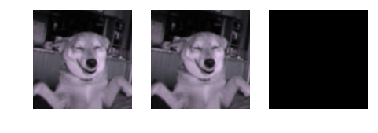

In [10]:
_, _, diff = compare_layer(sparse_A1, dense_A1)
print("Largest error layer 1:", np.max(diff))

Largest error layer 2: 0.0


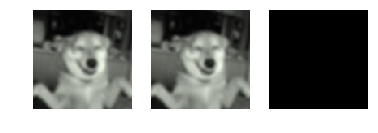

In [11]:
_, _, diff = compare_layer(sparse_A2, dense_A2)
print("Largest error layer 2:", np.max(diff))

Largest error layer 3: 0.0


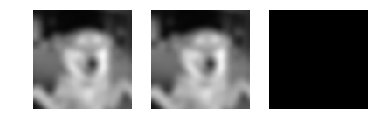

In [12]:
_, _, diff = compare_layer(sparse_A3, dense_A3)
print("Largest error layer 3:", np.max(diff))

#### Image without background

In [13]:
sparse_A1, sparse_A2, sparse_A3, dense_A1, dense_A2, dense_A3 = \
    build_3_layers_for_each_implementation(dog_no_bg_tensor, dog_no_bg_tf)

Largest error layer 1: 0.0


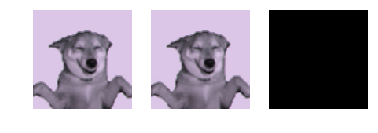

In [14]:
_, _, diff = compare_layer(sparse_A1, dense_A1)
print("Largest error layer 1:", np.max(diff))

Largest error layer 2: 0.0


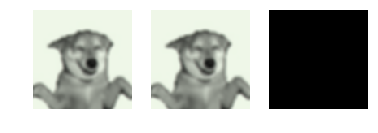

In [15]:
_, _, diff = compare_layer(sparse_A2, dense_A2)
print("Largest error layer 2:", np.max(diff))

Largest error layer 3: 0.0


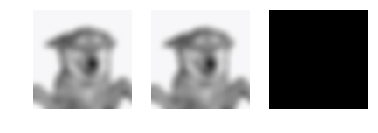

In [16]:
_, _, diff = compare_layer(sparse_A3, dense_A3)
print("Largest error layer 3:", np.max(diff))

### What next?
In this notebook I have described my implementation of a CNN layer for sparse images.

I validated the implementation by testing on two images - one with no sparsity and another with moderate sparsity (see the unit tests for more examples). Due to the overhead involved in setting up the dense matrix-matrix multiplication, images with much higher sparisty would be necessary to notice a performance gain. 

It will be fun to work out the gradient for this, and implement a sparse max pooling layer, so I can train a practical model with it. However, it would make sense to first implement the operation in C++ and CUDA and compare perforamnce with the standard dense CNNs.